# Quiver Quant Alternative Data

#### Imports

In [2]:
#supressing Pandas future warnings when indexing on datetime : https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import requests
import quiverquant
from configparser import ConfigParser
from io import BytesIO

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

parser = ConfigParser()
_ = parser.read('notebook.cfg')

nasdaq_auth_key = parser.get('my_api', 'nasd_key')
quant_auth_key = parser.get('my_api', 'quant_key')
alpha_auth_key = parser.get('my_api', 'alpha_key')

## Using QuiverQuant's API to Access Data

In [2]:
parser = ConfigParser()
_ = parser.read('notebook.cfg')
quant_auth_key = parser.get('my_api', 'quant_key')
url = "https://api.quiverquant.com/beta/historical/wikipedia/FB"
headers = {'accept': 'application/json',
'X-CSRFToken': 'TyTJwjuEC7VV7mOqZ622haRaaUr0x0Ng4nrwSRFKQs7vdoBcJlK9qjAS69ghzhFu',
'Authorization': f'Token {quant_auth_key}'}
r = requests.get(url, headers=headers)
df = df = pd.read_json(r.content)
df.head()

,Date,Ticker,Views,pct_change_week,pct_change_month
0,2016-10-17,FB,259,-29.343629,-30.888031
1,2016-10-24,FB,183,-29.343629,-30.888031
2,2016-10-31,FB,205,12.021858,-30.888031
3,2016-11-07,FB,180,-12.195122,-30.888031
4,2016-11-14,FB,179,-0.555556,-30.888031


## Using QuiverQuant Library to Access Data

In [5]:
#https://github.com/Quiver-Quantitative/python-api
token = quant_auth_key
quiver = quiverquant.quiver(token)

## Facebook - Data Exploration

#### WallStreetBets Data (Historical Daily)

In [42]:
WSB_quiver = quiver.wallstreetbets(ticker ='FB')

https://api.quiverquant.com/beta/historical/wallstreetbets/FB


In [45]:
WSB_quiver_weekly.tail()

,Date,Ticker,Mentions,Rank,Sentiment
1149,2021-12-11,FB,12,8,0.149533
1150,2021-12-12,FB,16,11,-0.055225
1151,2021-12-13,FB,67,7,-0.007169
1152,2021-12-14,FB,32,20,0.027284
1153,2021-12-15,FB,37,21,0.077130


In [44]:
WSB_quiver[['Mentions', 'Rank']].iloc[-2]

Mentions    32
Rank        20
Name: 1152, dtype: int64

In [43]:
WSB_quiver[['Mentions', 'Rank']].iloc[-1]

Mentions    37
Rank        21
Name: 1153, dtype: int64

In [55]:
WSB_quiver[['Mentions', 'Rank']].iloc[-1][0] 

37

In [56]:
WSB_quiver[['Mentions', 'Rank']].iloc[-2][0]

32

In [51]:
f"Mentions Daily Change : {WSB_quiver[['Mentions', 'Rank']].iloc[-1][0] / WSB_quiver[['Mentions', 'Rank']].iloc[-2][0]}"

'Mentions Daily Change : 1.15625'

In [54]:
"{:.2%}".format(WSB_quiver[['Mentions', 'Rank']].iloc[-1][0] / WSB_quiver[['Mentions', 'Rank']].iloc[-2][0])

'115.62%'

In [ ]:
f"Rank Weekly Change : {WSB_quiver_monthly[['Mentions', 'Rank']].iloc[-1][1]}"

'Rank Weekly Change : -0.045454545454545414'

In [29]:
WSB_quiver_monthly[['Mentions', 'Rank']].iloc[-1][1]

-0.045454545454545414

In [85]:
def get_wsb_stats(ticker):
    WSB_quiver = quiver.wallstreetbets(ticker =f'{ticker}')
    return WSB_quiver

In [ ]:
WSB_quiver_daily = quiver.wallstreetbets(ticker ='FB')

In [ ]:
WSB_quiver = get_wsb_stats(ticker)

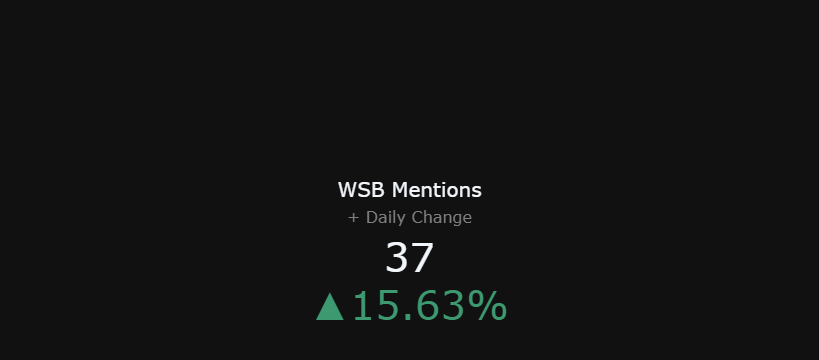

In [84]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    align = 'center', mode = "number+delta", value = WSB_quiver[['Mentions', 'Rank']].iloc[-1][0] ,
    title = {
        "text": "WSB Mentions<br><span style='font-size:0.8em;color:gray'>+ Daily Change</span><br><span style='font-size:0.8em;color:gray'>",
        'font':{
        'size':20}},
    delta = {
        'reference': WSB_quiver[['Mentions', 'Rank']].iloc[-2][0], 'relative': True, 'valueformat':'.2%',
        'font':{
        'size':40}},
    number = {
        'font':{
        'size':40}},
    domain = {
        'x': [0, 0], 'y': [0, 0.001]}))

fig.update_layout(
    paper_bgcolor=None, height=200, width=200, template='plotly_dark')

fig.show()

#### Streamlit doesn't allow importing quiverquant library, so have to reproduce with API call

In [58]:
ticker = 'FB'
url = f"https://api.quiverquant.com/beta/historical/wallstreetbets/{ticker}"
headers = {'accept': 'application/json',
'X-CSRFToken': 'TyTJwjuEC7VV7mOqZ622haRaaUr0x0Ng4nrwSRFKQs7vdoBcJlK9qjAS69ghzhFu',
'Authorization': f'Token {quant_auth_key}'}
r = requests.get(url, headers=headers)
df = pd.read_json(r.content)
df.head()

,Date,Ticker,Mentions,Rank,Sentiment
0,2018-08-01,FB,4,8,-0.054825
1,2018-08-02,FB,10,6,0.299040
2,2018-08-03,FB,10,5,0.005050
3,2018-08-06,FB,19,2,0.225889
4,2018-08-07,FB,13,5,-0.198246


In [59]:
df['Date'] = pd.to_datetime(df['Date'])

In [60]:
df.set_index('Date', inplace=True)

In [61]:
df = df.resample('M')['Mentions'].mean().to_frame()

In [62]:
df.tail()

,Mentions
Date,
2021-08-31,9.548387
2021-09-30,20.344828
2021-10-31,124.870968
2021-11-30,52.200000
2021-12-31,42.066667


In [63]:
# Monthly average mentions
df['Mentions'][-1]

42.06666666666667

In [51]:
df2 = pd.read_json(r.content)

In [52]:
df2['Date'] = pd.to_datetime(df2['Date'])

In [53]:
df2.set_index('Date', inplace=True)

In [54]:
df2 = df2.resample('W')['Mentions'].mean().to_frame()

In [55]:
df2.tail()

,Mentions
Date,
2021-11-21,56.428571
2021-11-28,41.142857
2021-12-05,53.857143
2021-12-12,32.285714
2021-12-19,46.000000


In [56]:
# Weekly average mentions
df2['Mentions'][-1]

46.0

#### Twitter Data (Historical Daily)

In [15]:
ticker = 'GME'
url = f"https://api.quiverquant.com/beta/historical/twitter/{ticker}"
headers = {'accept': 'application/json',
'X-CSRFToken': 'TyTJwjuEC7VV7mOqZ622haRaaUr0x0Ng4nrwSRFKQs7vdoBcJlK9qjAS69ghzhFu',
'Authorization': f'Token {quant_auth_key}'}
r = requests.get(url, headers=headers)
df = pd.read_json(r.content)
df.head(6)

,Date,Ticker,Followers,pct_change_day,pct_change_week,pct_change_month
0,2021-12-15,GME,1857169,0.041101,0.224067,1.347300
1,2021-12-13,GME,1856406,0.021929,0.256473,1.366234
2,2021-12-12,GME,1855999,0.022203,0.249273,1.387247
3,2021-12-11,GME,1855587,0.022586,0.240826,1.389720
4,2021-12-10,GME,1855168,0.037369,0.234273,1.398018
5,2021-12-09,GME,1854475,0.039973,0.227047,1.389733


In [19]:
df['Followers'][0] / df['Followers'][31]

1.0150738690089036

In [27]:
quiver.twitter(ticker='FB').sort_values('Date', ascending=True).head()

,Date,Ticker,Followers,pct_change_day,pct_change_week,pct_change_month
478,2020-05-02,FB,13467018,0.006579,0.027705,-0.205672
477,2020-05-03,FB,13467293,0.002042,0.027883,-0.176472
476,2020-05-05,FB,13465836,-0.010819,0.015531,-0.113410
475,2020-05-06,FB,13464762,-0.007976,0.010473,-0.065120
474,2020-05-07,FB,13464234,-0.003921,-0.001255,0.008557


In [6]:
twitter_data = quiver.twitter(ticker='FB')

In [18]:
twitter_data[['Date', 'Ticker', 'Followers']].tail()

,Date,Ticker,Followers
474,2020-05-07,FB,13464234
475,2020-05-06,FB,13464762
476,2020-05-05,FB,13465836
477,2020-05-03,FB,13467293
478,2020-05-02,FB,13467018


#### Wikipedia Pageviews (Historical Weekly)

In [20]:
quiver.wikipedia(ticker='FB').tail()

,Date,Ticker,Views,pct_change_week,pct_change_month
264,2021-11-08,FB,4532.0,-95.358745,-97.865928
265,2021-11-15,FB,2966.0,-34.554281,-98.222696
266,2021-11-22,FB,1626.0,-45.178692,-99.098864
267,2021-11-29,FB,1644.0,1.107011,-98.316367
268,2021-12-06,FB,1574.0,-4.257908,-65.269197


#### Congress Trading (Historical)

In [6]:
quiver.congress_trading(ticker='FB', politician=False).head()

,ReportDate,TransactionDate,Ticker,Representative,Transaction,Amount,House,Range
0,2021-11-15,2021-10-27,FB,Josh Gottheimer,Sale,1001.0,Representatives,"$1,001-$15,000"
1,2021-11-15,2021-10-26,FB,Josh Gottheimer,Sale,1001.0,Representatives,"$1,001-$15,000"
2,2021-11-15,2021-10-18,FB,Josh Gottheimer,Sale,1001.0,Representatives,"$1,001-$15,000"
3,2021-09-08,2021-08-13,FB,Marie Newman,Sale,15001.0,Representatives,"$15,001-$50,000"
4,2021-09-08,2021-08-02,FB,Marie Newman,Purchase,15001.0,Representatives,"$15,001-$50,000"


#### OTC Short Percentages (Historical)

In [21]:
quiver.offexchange(ticker='FB').head()

,Date,Ticker,OTC_Short,OTC_Total,DPI
0,2021-12-14,FB,3521984,6869169,0.512723
1,2021-12-13,FB,3777907,8929714,0.423071
2,2021-12-10,FB,2344664,4927749,0.475808
3,2021-12-09,FB,3329667,6122207,0.543867
4,2021-12-08,FB,3503561,6659048,0.526135


In [12]:
quiver.offexchange(ticker='FB').head()

,Date,Ticker,OTC_Short,OTC_Total,DPI
0,2021-12-14,FB,3521984,6869169,0.512723
1,2021-12-13,FB,3777907,8929714,0.423071
2,2021-12-10,FB,2344664,4927749,0.475808
3,2021-12-09,FB,3329667,6122207,0.543867
4,2021-12-08,FB,3503561,6659048,0.526135


In [51]:
otc_data = quiver.offexchange(ticker='FB')[['Date', 'DPI']].sort_values(by='Date', ascending=True)

## Function Combining Several Sentiment Indicators  

In [144]:
def alt_dataframe(ticker, start_date, end_date):
    wsb_data = quiver.wallstreetbets(ticker ='FB')
    wsb_data['Date'] = pd.to_datetime(wsb_data['Date'])
    wsb_data.set_index('Date', inplace=True)
    congress_data = quiver.congress_trading(ticker='FB', politician=False).sort_values(by='ReportDate', ascending=True)[['ReportDate', 'Transaction']]
    congress_data['Transaction'] = congress_data['Transaction'].map({'Purchase' : 1, 'Sale' : -1})
    congress_data['ReportDate'] = pd.to_datetime(congress_data['ReportDate'])
    congress_data.set_index('ReportDate', inplace=True)
    otc_data = quiver.offexchange(ticker='FB')[['Date', 'DPI']].sort_values(by='Date', ascending=True)
    otc_data['Date'] = pd.to_datetime(otc_data['Date'])
    otc_data.set_index('Date', inplace=True)
    df = otc_data.join(congress_data)
    df2 = df.join(wsb_data)
    df2 = df2[df2.index >= f'{start_date}']
    df2 = df2[df2.index <= f'{end_date}']
    df2['Transaction'].fillna(0, inplace=True)
    return df2

In [146]:
ticker = 'FB'
start_date = '2021-01-01'
end_date = '2021-12-10'
alt_dataframe(ticker, start_date, end_date).head()

https://api.quiverquant.com/beta/historical/wallstreetbets/FB


,DPI,Transaction,Ticker,Mentions,Rank,Sentiment
2021-01-04,0.319705,0.0,FB,22.0,67.0,0.010582
2021-01-05,0.346115,0.0,FB,37.0,44.0,0.074581
2021-01-06,0.325061,0.0,FB,98.0,25.0,-0.029316
2021-01-07,0.301306,0.0,FB,76.0,25.0,0.021668
2021-01-08,0.341858,0.0,FB,63.0,24.0,-0.074205
